# Util Bloqs

The utility bloqs let you reshape Soquets.

In [1]:
from qualtran.drawing import GraphDrawer, PrettyGraphDrawer, show_bloq
from qualtran.bloqs.util_bloqs import Split, Join, Partition
import numpy as np

from IPython.display import SVG

## Split and Join

Split and join take a `bitsize=n, shape=()` to `bitsize=1, shape=(n,)` and back.

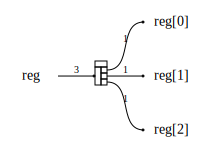

In [2]:
show_bloq(Split(3))

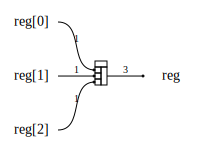

In [3]:
show_bloq(Join(3))

## SplitJoin

For fun, we can pair `Split` and `Join` into an identity operation.

In [4]:
from attrs import frozen
from functools import cached_property
from typing import *
from qualtran import Bloq, Signature, Register
from qualtran.bloqs.basic_gates import CNOT

@frozen
class SplitJoin(Bloq):
    n: int

    @cached_property
    def signature(self) -> Signature:
        return Signature([Register('x', self.n)])

    def build_composite_bloq(
        self, bb: 'BloqBuilder', *, x: 'Soquet'
    ) -> Dict[str, 'Soquet']:
        xs = bb.split(x)
        xs[0], xs[1] = bb.add(CNOT(), ctrl=xs[0], target=xs[1])
        x = bb.join(xs)
        return {'x': x}

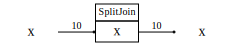

In [5]:
show_bloq(SplitJoin(10))

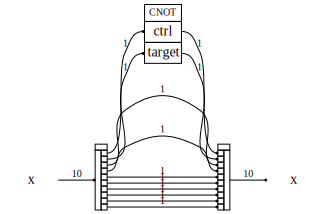

In [6]:
show_bloq(SplitJoin(10).decompose_bloq())

## Partition

A Partition is a useful bloq for abstracting away the details of large registers (like multiple selection registers, spin, orbital, ...). We can use a partition bloq to hide these detailed registers until we decompose the bloq further.

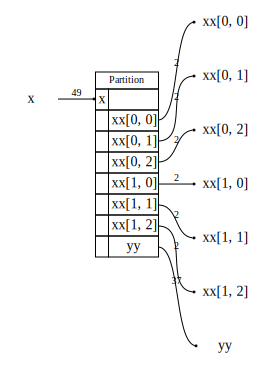

In [7]:
regs = (Register('xx', 2, shape=(2,3)), Register('yy', 37))
bitsize = sum(reg.total_bits() for reg in regs)
bloq = Partition(n=bitsize, regs=regs)
show_bloq(bloq)

An example of using a `Partition` as part of a decomposition is given below:

In [8]:
from qualtran import BloqBuilder, Soquet, SoquetT
from qualtran.bloqs.for_testing import TestMultiRegister

@frozen
class BlackBoxBloq(Bloq):
    subbloq: Bloq

    @cached_property
    def bitsize(self):
        return sum(reg.total_bits() for reg in self.subbloq.signature)

    @cached_property
    def signature(self) -> Signature:
        return Signature.build(system=self.bitsize)

    def build_composite_bloq(self, bb: 'BloqBuilder', system: 'SoquetT') -> Dict[str, 'Soquet']:
        bloq_regs = self.subbloq.signature
        partition = Partition(self.bitsize, bloq_regs)
        partitioned_vars = bb.add(partition, x=system)
        partitioned_vars = bb.add(
            self.subbloq, **{reg.name: sp for reg, sp in zip(bloq_regs, partitioned_vars)}
        )
        system = bb.add(
            partition.adjoint(), **{reg.name: sp for reg, sp in zip(bloq_regs, partitioned_vars)}
        )
        return {'system': system}
    
    def short_name(self) -> str:
        return "BBBloq" 

As an example, we'll use the generic `TestMultiRegister` bloq as our sub-bloq with many registers. It does different (contrived) things to the `xx`, `yy`, and `zz` registers:

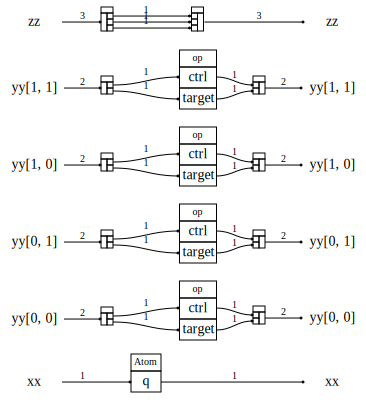

In [9]:
subbloq = TestMultiRegister()
show_bloq(subbloq.decompose_bloq())

By wrapping it in `BlackBoxBloq`, the previously-complicated signature is now just one register named "system" with a larger bitsize.

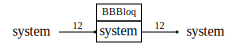

In [10]:
show_bloq(BlackBoxBloq(subbloq))

`Partition` adapts between the two register sets. We can inspect this in the decomposition:

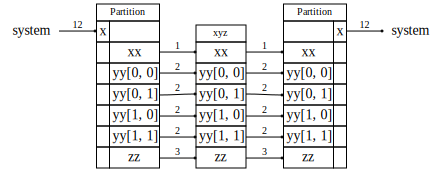

In [11]:
show_bloq(BlackBoxBloq(subbloq).decompose_bloq())